# Displacement field NWES
Following the tutorial of https://docs.oceanparcels.org/en/latest/examples/documentation_unstuck_Agrid.html   
we create a displacement field for the CMEMS data of NWES https://data.marine.copernicus.eu/product/NWSHELF_ANALYSISFORECAST_PHY_004_013/description  
we use the new NWES data (from september 2023 onwards)

In [1]:
# import needed packages


from copy import copy

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import xarray as xr
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from netCDF4 import Dataset
from scipy import interpolate

import parcels

In [2]:
# set directories and files
base_directory_in = '/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/'
filename_in_new = 'CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_20230901_20230901_R20230902_HC01.nc'
filename_in_old = 'metoffice_foam1_amm15_NWS_CUR_b20230903_hi20230901.nc' 
# there is a old (till nov 2023) and new (from sep 2023) version
versions = np.array(['old','new'])
models = {}
models['old'] = {}
models['new'] = {}
data_new = xr.open_dataset(base_directory_in+filename_in_new)
data_old = xr.open_dataset(base_directory_in+filename_in_old)
models['old']['lon'] = data_old['lon'].values
models['old']['lat'] = data_old['lat'].values
models['new']['lon'] = data_new['longitude'].values
models['new']['lat'] = data_new['latitude'].values

print(data_new.attrs['source'])
print(data_old.attrs['source'])


NEMO3.6
PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWATCH-III v4.18_NEMOVAR v6


In [68]:
print(data_old
      )

<xarray.Dataset> Size: 8GB
Dimensions:  (time: 24, lat: 1240, lon: 958, depth: 33)
Coordinates:
  * time     (time) datetime64[ns] 192B 2023-09-01T01:00:00 ... 2023-09-02
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
Data variables:
    uo       (time, depth, lat, lon) float32 4GB ...
    vo       (time, depth, lat, lon) float32 4GB ...
Attributes: (12/13)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and

In [3]:
# functions needed to create landmask field and displacement field

def make_landmask(fielddata):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf file.
    """
    datafile = Dataset(fielddata)

    landmask = datafile.variables["uo"][0, 0]
    landmask = np.ma.masked_invalid(landmask)
    landmask = landmask.mask.astype("int")

    return landmask

def get_coastal_nodes(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes directly
    next to land. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4 * landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype("int")

    return coastal


def get_shore_nodes(landmask):
    """Function that detects the shore nodes, i.e. the land nodes directly
    next to the ocean. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4 * landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype("int")

    return shore

def get_coastal_nodes_diagonal(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes where
    one of the 8 nearest nodes is land. Computes the Laplacian of landmask
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1, 1), axis=(0, 1)) + np.roll(
        landmask, (1, 1), axis=(0, 1)
    )
    mask_lap += np.roll(landmask, (-1, -1), axis=(0, 1)) + np.roll(
        landmask, (1, -1), axis=(0, 1)
    )
    mask_lap -= 8 * landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype("int")

    return coastal


def get_shore_nodes_diagonal(landmask):
    """Function that detects the shore nodes, i.e. the land nodes where
    one of the 8 nearest nodes is ocean. Computes the Laplacian of landmask
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1, 1), axis=(0, 1)) + np.roll(
        landmask, (1, 1), axis=(0, 1)
    )
    mask_lap += np.roll(landmask, (-1, -1), axis=(0, 1)) + np.roll(
        landmask, (1, -1), axis=(0, 1)
    )
    mask_lap -= 8 * landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype("int")

    return shore

def create_displacement_field(landmask, double_cell=False):
    """Function that creates a displacement field 1 m/s away from the shore.

    - landmask: the land mask dUilt using `make_landmask`.
    - double_cell: Boolean for determining if you want a double cell.
      Default set to False.

    Output: two 2D arrays, one for each camponent of the velocity.
    """
    shore = get_shore_nodes(landmask)

    # nodes bordering ocean directly and diagonally
    shore_d = get_shore_nodes_diagonal(landmask)
    # corner nodes that only border ocean diagonally
    shore_c = shore_d - shore

    # Simple derivative
    Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)

    Ly_c = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    # Include y-component of diagonal neighbors
    Ly_c += np.roll(landmask, (-1, -1), axis=(0, 1)) + np.roll(
        landmask, (-1, 1), axis=(0, 1)
    )
    Ly_c += -np.roll(landmask, (1, -1), axis=(0, 1)) - np.roll(
        landmask, (1, 1), axis=(0, 1)
    )

    Lx_c = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    # Include x-component of diagonal neighbors
    Lx_c += np.roll(landmask, (-1, -1), axis=(1, 0)) + np.roll(
        landmask, (-1, 1), axis=(1, 0)
    )
    Lx_c += -np.roll(landmask, (1, -1), axis=(1, 0)) - np.roll(
        landmask, (1, 1), axis=(1, 0)
    )

    v_x = -Lx * (shore)
    v_y = -Ly * (shore)

    v_x_c = -Lx_c * (shore_c)
    v_y_c = -Ly_c * (shore_c)

    v_x = v_x + v_x_c
    v_y = v_y + v_y_c

    magnitude = np.sqrt(v_y**2 + v_x**2)
    # the coastal nodes between land create a problem. Magnitude there is zero
    # I force it to be 1 to avoid problems when normalizing.
    ny, nx = np.where(magnitude == 0)
    magnitude[ny, nx] = 1

    v_x = v_x / magnitude
    v_y = v_y / magnitude

    return v_x, v_y

def distance_to_shore(landmask, dx=1):
    """Function that computes the distance to the shore. It is based in the
    the `get_coastal_nodes` algorithm.

    - landmask: the land mask dUilt using `make_landmask` function.
    - dx: the grid cell dimension. This is a crude approxsimation of the real
    distance (be careful).

    Output: 2D array containing the distances from shore.
    """
    ci = get_coastal_nodes(landmask)  # direct neighbors
    dist = ci * dx  # 1 dx away

    ci_d = get_coastal_nodes_diagonal(landmask)  # diagonal neighbors
    dist_d = (ci_d - ci) * np.sqrt(2 * dx**2)  # sqrt(2) dx away

    return dist + dist_d

In [64]:
# create landmask, distance to shore and displacement field 

models['new']['landmask'] = make_landmask(base_directory_in+filename_in_new)
models['old']['landmask'] = make_landmask(base_directory_in+filename_in_old)

for vers in versions:
    models[vers]['d_2_s'] = distance_to_shore(models[vers]['landmask']) 
    v_x, v_y = create_displacement_field(models[vers]['landmask'])

    models[vers]['v_x'] = v_x
    models[vers]['v_y'] = v_y



In [65]:
# save fields to netcdf file
output_directory = '/storage/shared/oceanparcels/output_data/data_Meike/NWES/'
for vers in versions:
    dset = xr.Dataset(
    data_vars=dict(dispU=(['lat','lon'],models[vers]['v_x']),
                   dispV=(['lat','lon'],models[vers]['v_y']),
                   landmask=(['lat','lon'],models[vers]['landmask']),
                   distance2shore=(['lat','lon'],models[vers]['d_2_s'])),
                    coords=dict(
                            lon=('lon',models[vers]['lon']),
                            lat=('lat',models[vers]['lat'])
                    ),
                    attrs=dict(
                        title='anti beaching fields NWES ' + vers,
                        contact = 'm.f.bos@uu.nl')
    )
    dset.to_netcdf(output_directory+'anti_beaching_NWES_'+vers+'.nc')

## Plotting fields
below we provide the stript to plot the landmasks and the fields 

In [54]:
for vers in versions:
    models[vers]['dlon'] = models[vers]['lon'][11] -  models[vers]['lon'][10]
    models[vers]['dlat'] = models[vers]['lat'][11] -  models[vers]['lat'][10]
    models[vers]['lonmin'] = 200 
    models[vers]['lonmax'] = 220
    models[vers]['latmin'] = 200
    models[vers]['latmax'] = 220



In [55]:
# for plotting
for vers in versions:
    lon_vals, lat_vals = np.meshgrid(models[vers]['lon'], models[vers]['lat'])
    models[vers]['lon_vals']=lon_vals
    models[vers]['lat_vals']=lat_vals
    models[vers]['lons_plot'] = lon_vals[models[vers]['latmin']:models[vers]['latmax'], models[vers]['lonmin']:models[vers]['lonmax']]
    models[vers]['lats_plot'] = lat_vals[models[vers]['latmin']:models[vers]['latmax'], models[vers]['lonmin']:models[vers]['lonmax']]



    x = models[vers]['lon'][:-1] + np.diff(models[vers]['lon']) / 2
    y = models[vers]['lat'][:-1] + np.diff(models[vers]['lat']) / 2
    lon_centers, lat_centers = np.meshgrid(x, y)
    models[vers]['lon_centers'] = lon_centers
    models[vers]['lat_centers'] = lat_centers

color_land = copy(plt.get_cmap("Reds"))(0)
color_ocean = copy(plt.get_cmap("Reds"))(128)



In [32]:
# Interpolate the landmask to the cell centers
# only cells with 4 neighboring land points will be land
fl = interpolate.RectBivariateSpline(
    models['new']['data']["latitude"], models['new']['data']["longitude"], models['new']['landmask'], kx=1, ky=1
)

models['new']['l_centers'] = fl(models['new']['lat_centers'][:, 0], models['new']['lon_centers'][0, :])

# land when interpolated value == 1
models['new']['lmask']  = np.ma.masked_values(models['new']['l_centers'] , 1)

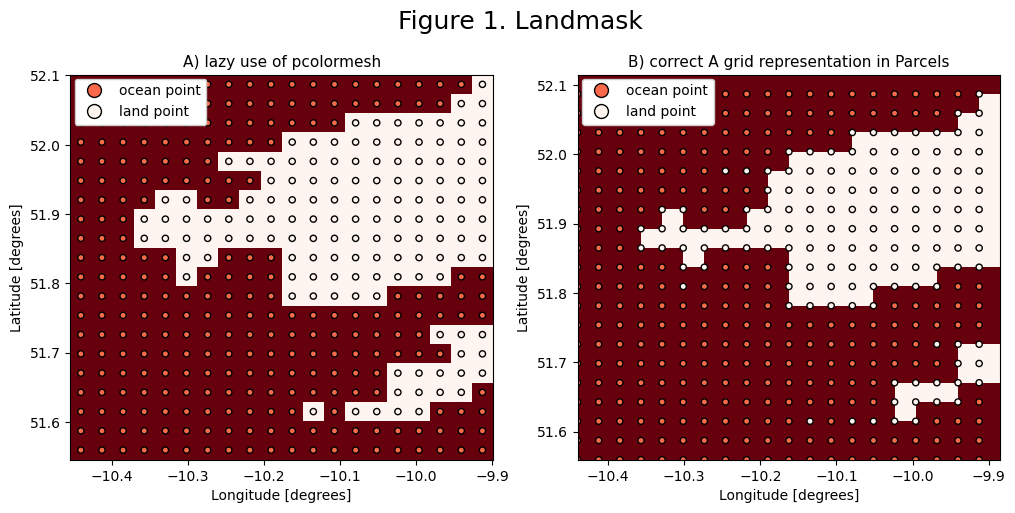

In [33]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Figure 1. Landmask", fontsize=18, y=1.01)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_title("A) lazy use of pcolormesh", fontsize=11)
ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")

land0 = ax0.pcolormesh(
    models['new']['lons_plot'] ,
    models['new']['lats_plot'] ,
    models['new']['landmask'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    cmap="Reds_r",
    shading="auto",
)
ax0.scatter(
    models['new']['lons_plot'] ,
    models['new']['lats_plot'],
    c=models['new']['landmask'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    s=20,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)

custom_lines = [
    Line2D(
        [0], [0], c=color_ocean, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
    Line2D(
        [0], [0], c=color_land, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
]
ax0.legend(
    custom_lines,
    ["ocean point", "land point"],
    bbox_to_anchor=(0.01, 0.93),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
)

ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title("B) correct A grid representation in Parcels", fontsize=11)
ax1.set_ylabel("Latitude [degrees]")
ax1.set_xlabel("Longitude [degrees]")

land1 = ax1.pcolormesh(
    models['new']['lon_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lat_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lmask'].mask[ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    cmap="Reds_r",
)
ax1.scatter(
    models['new']['lons_plot'],
    models['new']['lats_plot'],
    c=models['new']['landmask'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    s=20,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)

ax1.legend(
    custom_lines,
    ["ocean point", "land point"],
    bbox_to_anchor=(0.01, 0.93),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
);

In [36]:
models['new']['coastal'] = get_coastal_nodes_diagonal(models['new']['landmask'])
models['new']['shore'] = get_shore_nodes_diagonal(models['new']['landmask'])

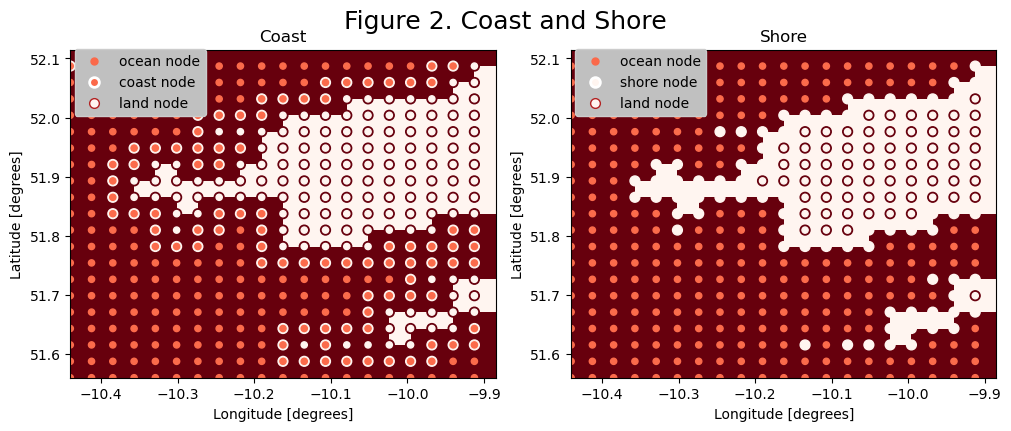

In [38]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
fig.suptitle("Figure 2. Coast and Shore", fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)


ax0 = fig.add_subplot(gs[0, 0])
land0 = ax0.pcolormesh(
    models['new']['lon_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lat_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lmask'].mask[ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    cmap="Reds_r",
)
coa = ax0.scatter(
    models['new']['lons_plot'], models['new']['lats_plot'], c=models['new']['coastal'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']], cmap="Reds_r", s=50
)
ax0.scatter(
     models['new']['lons_plot'],
     models['new']['lats_plot'],
    c=models['new']['landmask'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    s=20,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
)

ax0.set_title("Coast")
ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")

custom_lines = [
    Line2D([0], [0], c=color_ocean, marker="o", markersize=5, lw=0),
    Line2D(
        [0],
        [0],
        c=color_ocean,
        marker="o",
        markersize=7,
        markeredgecolor="w",
        markeredgewidth=2,
        lw=0,
    ),
    Line2D(
        [0],
        [0],
        c=color_land,
        marker="o",
        markersize=7,
        markeredgecolor="firebrick",
        lw=0,
    ),
]
ax0.legend(
    custom_lines,
    ["ocean node", "coast node", "land node"],
    bbox_to_anchor=(0.01, 0.9),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
    facecolor="silver",
)


ax1 = fig.add_subplot(gs[0, 1])
land1 = ax1.pcolormesh(
    models['new']['lon_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lat_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lmask'].mask[ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    cmap="Reds_r",
)
sho = ax1.scatter(
    models['new']['lons_plot'], models['new']['lats_plot'], c=models['new']['shore'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']], cmap="Reds_r", s=50
)
ax1.scatter(
    models['new']['lons_plot'],
    models['new']['lats_plot'],
    c=models['new']['landmask'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    s=20,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
)

ax1.set_title("Shore")
ax1.set_ylabel("Latitude [degrees]")
ax1.set_xlabel("Longitude [degrees]")

custom_lines = [
    Line2D([0], [0], c=color_ocean, marker="o", markersize=5, lw=0),
    Line2D(
        [0],
        [0],
        c=color_land,
        marker="o",
        markersize=7,
        markeredgecolor="w",
        markeredgewidth=2,
        lw=0,
    ),
    Line2D(
        [0],
        [0],
        c=color_land,
        marker="o",
        markersize=7,
        markeredgecolor="firebrick",
        lw=0,
    ),
]
ax1.legend(
    custom_lines,
    ["ocean node", "shore node", "land node"],
    bbox_to_anchor=(0.01, 0.9),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
    facecolor="silver",
);



In [40]:
v_x, v_y = create_displacement_field(models['new']['landmask'])

models['new']['v_x'] = v_x
models['new']['v_y'] = v_y

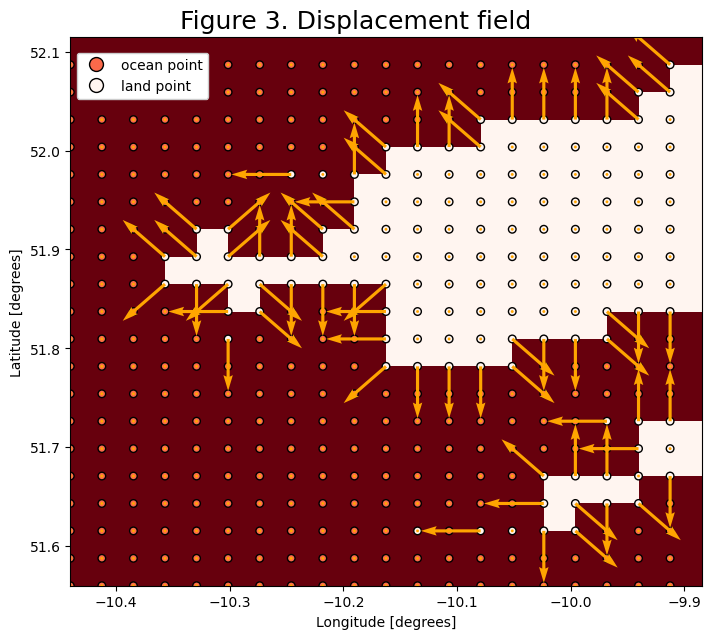

In [41]:
fig = plt.figure(figsize=(7, 6), constrained_layout=True)
fig.suptitle("Figure 3. Displacement field", fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
land = ax0.pcolormesh(
    models['new']['lon_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lat_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lmask'].mask[ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    cmap="Reds_r",
)
ax0.scatter(
    models['new']['lons_plot'],
    models['new']['lats_plot'],
    c=models['new']['landmask'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    s=30,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
quiv = ax0.quiver(
    models['new']['lons_plot'],
    models['new']['lats_plot'],
    models['new']['v_x'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    models['new']['v_y'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    color="orange",
    angles="xy",
    scale_units="xy",
    scale=19,
    width=0.005,
)

ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")

custom_lines = [
    Line2D(
        [0], [0], c=color_ocean, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
    Line2D(
        [0], [0], c=color_land, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
]
ax0.legend(
    custom_lines,
    ["ocean point", "land point"],
    bbox_to_anchor=(0.01, 0.93),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
);

In [43]:
models['new']['d_2_s'] = distance_to_shore(models['new']['landmask'])

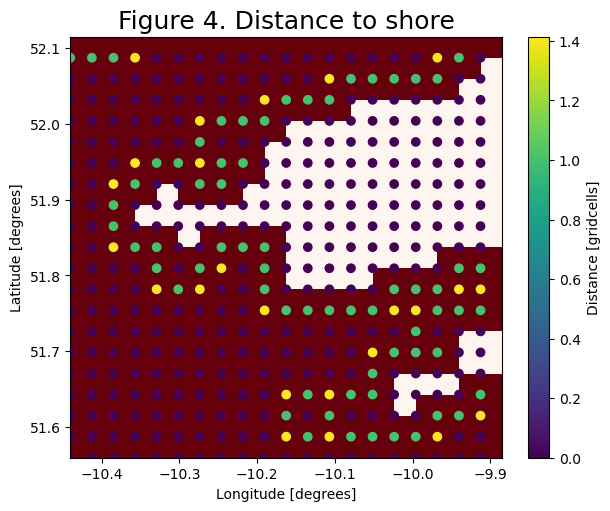

In [44]:
fig = plt.figure(figsize=(6, 5), constrained_layout=True)

ax0 = fig.add_subplot()
ax0.set_title("Figure 4. Distance to shore", fontsize=18)
ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")

land = ax0.pcolormesh(
    models['new']['lon_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lat_vals'][ models['new']['latmin']: models['new']['latmax']+1,  models['new']['lonmin']: models['new']['lonmax']+1],
    models['new']['lmask'].mask[ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']],
    cmap="Reds_r",
)
d2s = ax0.scatter(['lons_plot'], models['new']['lats_plot'], c=models['new']['d_2_s'][ models['new']['latmin']: models['new']['latmax'],  models['new']['lonmin']: models['new']['lonmax']])

plt.colorbar(d2s, ax=ax0, label="Distance [gridcells]");

